In [1]:
import os
import importlib

import cfGPR
import vonkarmanFT as vk
import plotGPR

import numpy as np
import matplotlib.pyplot as plt
import astropy.stats as stats
import astropy.units as u
import scipy.optimize as opt
from scipy.spatial.ckdtree import cKDTree

In [2]:
def getGrid(X1, X2):
    u1, u2 = X1[:, 0], X2[:, 0]
    v1, v2 = X1[:, 1], X2[:, 1]
    uu1, uu2 = np.meshgrid(u1, u2)
    vv1, vv2 = np.meshgrid(v1, v2)
    
    return uu1 - uu2, vv1 - vv2

In [3]:
GP = cfGPR.CurlFreeGPR()
GP.load_fits("folio2")
GP.extract_data(465)
GP.sigma_clip()
GP.split_data(train_size=0.50)

x = GP.Xtest[:, 0]*u.deg
y = GP.Xtest[:, 1]*u.deg
dx = GP.Ytest[:, 0]*u.mas
dy = GP.Ytest[:, 1]*u.mas
err = GP.Etest[:, 0]*u.mas

In [27]:
# Really good parameters for exposure 465 from FoM A
params = np.array([
    206.400264,
    17.376640,
    -0.000061,
    0.017663,
    0.036065
])

# (465) From FoM B when starting optimizer from best params from FoM A
# Note that diameter actually showed 0 but that produced a non pos def
# error so i add a 1 on the end
# params = np.array([
#     272.902608,
#     498.267088,
#     0.0000001,
#     0.015410,
#     0.025771
# ])

ttt = vk.TurbulentLayer(
    variance=params[0],
    outerScale=params[1],
    diameter=params[2],
    wind=(params[3], params[4]))

/home/fortino/DESworkspace/vonkarmanFT.py:65: RuntimeWarning: divide by zero encountered in true_divide
  airy = (j1(kR)/(kR))**2
/home/fortino/DESworkspace/vonkarmanFT.py:65: RuntimeWarning: invalid value encountered in true_divide
  airy = (j1(kR)/(kR))**2
/home/fortino/DESworkspace/vonkarmanFT.py:75: RuntimeWarning: divide by zero encountered in true_divide
  w = np.where(kWind==0, 1., np.sin(kWind) / kWind)
/home/fortino/DESworkspace/vonkarmanFT.py:75: RuntimeWarning: invalid value encountered in true_divide
  w = np.where(kWind==0, 1., np.sin(kWind) / kWind)


In [28]:
du, dv = getGrid(GP.Xtrain, GP.Xtrain)
Cuv = ttt.getCuv(du, dv, workers=24)
Cuv[:, :, 0, 1] *= 0
Cuv[:, :, 1, 0] *= 0
n1, n2 = Cuv.shape[0], Cuv.shape[1]
K = np.swapaxes(Cuv, 1, 2).reshape(2*n1, 2*n2)

du, dv = getGrid(GP.Xtest, GP.Xtrain)
Cuv = ttt.getCuv(du, dv, workers=24)
Cuv[:, :, 0, 1] *= 0
Cuv[:, :, 1, 0] *= 0
n1, n2 = Cuv.shape[0], Cuv.shape[1]
Ks = np.swapaxes(Cuv, 1, 2).reshape(2*n1, 2*n2)

W = GP.white_noise_kernel(GP.Etrain)

L = np.linalg.cholesky(K + W)

alpha = np.linalg.solve(L.T, np.linalg.solve(L, GP.flat(GP.Ytrain)))

GP.fbar_s = GP.unflat(np.dot(Ks.T, alpha))

In [29]:
# # Fom Method C
res = GP.Ytest - GP.fbar_s
rMax = (0.2*u.deg).to(u.deg).value
rMin = (5*u.mas).to(u.deg).value
kdt = cKDTree(GP.Xtest)
prs_set = kdt.query_pairs(rMax, output_type='set')
prs_set -= kdt.query_pairs(rMin, output_type='set')
prs = np.array(list(prs_set))
xiplus = np.mean(np.sum(res[prs[:, 0]] * res[prs[:, 1]], axis=1))
print(xiplus)

# # Fom Method B
res = GP.Ytest - GP.fbar_s
rMax = (0.02*u.deg).to(u.deg).value
rMin = (5*u.mas).to(u.deg).value
kdt = cKDTree(GP.Xtest)
prs_set = kdt.query_pairs(rMax, output_type='set')
prs_set -= kdt.query_pairs(rMin, output_type='set')
prs = np.array(list(prs_set))
xiplus = np.mean(np.sum(res[prs[:, 0]] * res[prs[:, 1]], axis=1))
print(xiplus)

# Fom Method A
res = GP.Ytest - GP.fbar_s
rMax = (0.2*u.deg).to(u.deg).value
rMin = (5*u.mas).to(u.deg).value
r = np.linspace(rMin, rMax, 100)
kdt = cKDTree(GP.Xtest)
xiplus = np.zeros(r.shape)
for i, radius in enumerate(r):
    prsmax = kdt.query_pairs(r[i], output_type='ndarray')
    xiplus[i] = np.nanmean(res[prsmax][:, 0, :] * res[prsmax][:, 1, :])
xiplus = np.nanmean(xiplus)
print(xiplus)

1.710574523111414
34.24853420798851


/home/fortino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


5.233707104618195


In [30]:
x = GP.Xtest[:, 0]*u.deg
y = GP.Xtest[:, 1]*u.deg
dx = GP.Ytest[:, 0]*u.mas
dy = GP.Ytest[:, 1]*u.mas
err = GP.Etest[:, 0]*u.mas

x2 = GP.Xtest[:, 0]*u.deg
y2 = GP.Xtest[:, 1]*u.deg
dx2 = GP.Ytest[:, 0]*u.mas - GP.fbar_s[:, 0]*u.mas
dy2 = GP.Ytest[:, 1]*u.mas - GP.fbar_s[:, 1]*u.mas
err2 = GP.Etest[:, 0]*u.mas

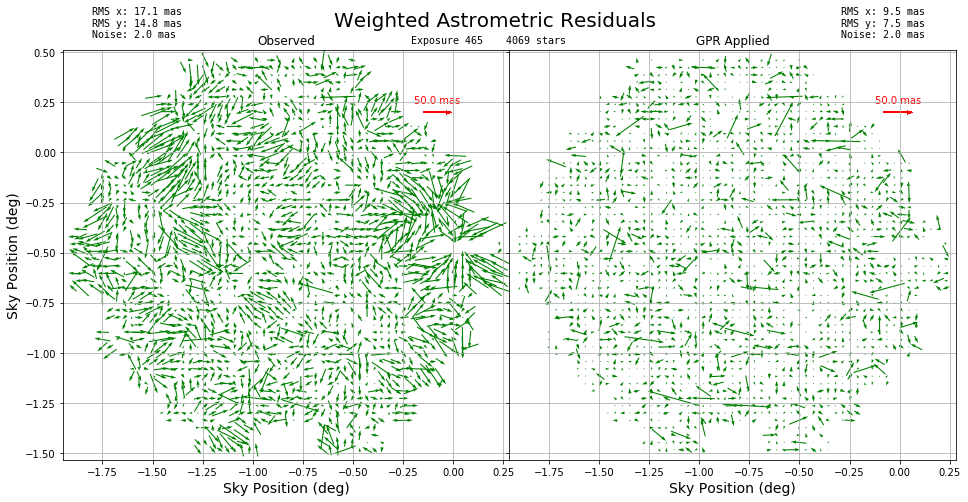

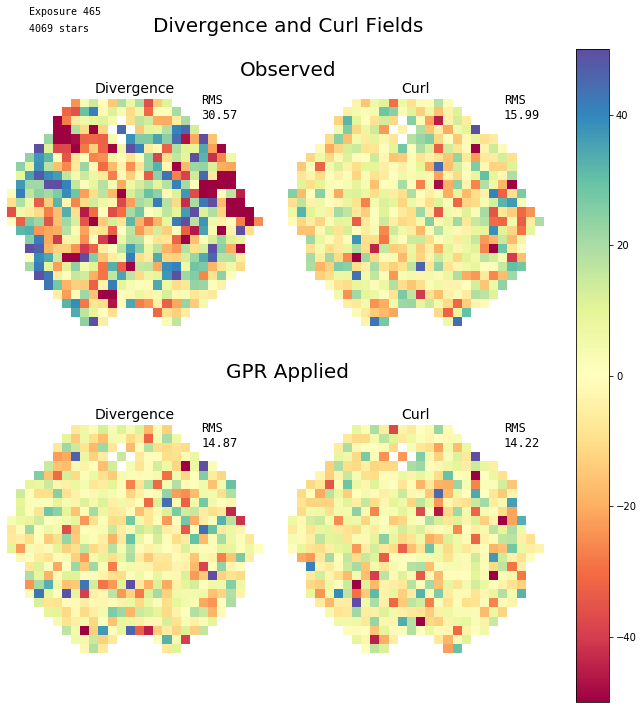

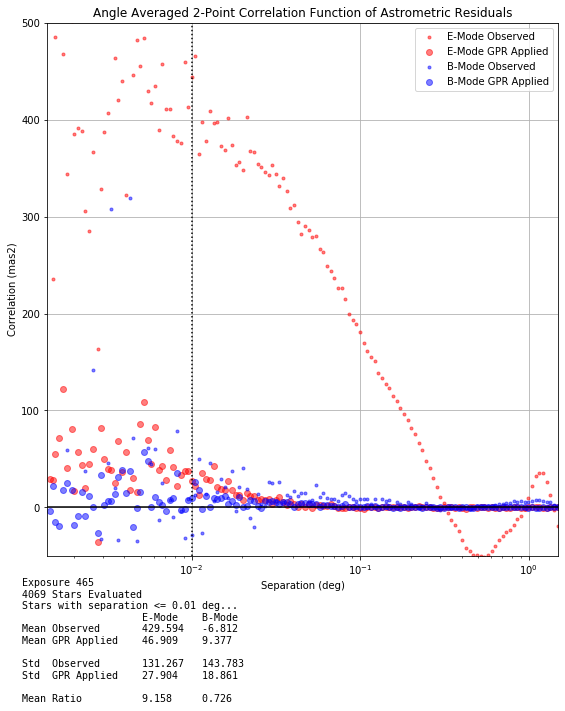

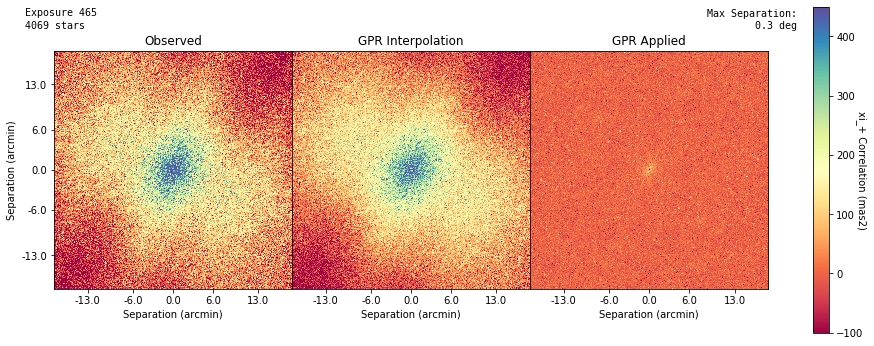

In [31]:
plotGPR.AstrometricResiduals(
    x, y, dx, dy, err,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2, err2=err2,
    title1="Observed", title2="GPR Applied",
    minPoints=100,
    pixelsPerBin=500,
    maxErr=50*u.mas,
    scale=350*u.mas,
    arrowScale=50*u.mas,
    savePath=None, saveExt="",
    plotShow=True,
    exposure=465
    )

plotGPR.DivCurl(
    x, y, dx, dy, err,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2, err2=err2,
    title1="Observed", title2="GPR Applied",
    minPoints=100,
    pixelsPerBin=1000,
    maxErr=50*u.mas,
    scale=50,
    savePath=None, saveExt=None,
    plotShow=True,
    exposure=465
)

plotGPR.Correlation(
    x, y, dx, dy,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2,
    title1="Observed", title2="GPR Applied",
    xiE_ON=True, xiB_ON=True,
#     xiplus_ON=True, ximinus_ON=True,
#     xicross_ON=True, xiz2_ON=True,
    rmin=5*u.arcsec, rmax=1.5*u.deg, dlogr=0.05,
    ylim=(-50, 500),
    sep=1e-2*u.deg, avgLine=True,
    savePath=None, saveExt=None,
    plotShow=True,
    exposure=465,
    showInfo=True
    )

plotGPR.Correlation2D(
    x, y, dx, dy,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2,
    title1="Observed", title2="GPR Applied", title3="GPR Interpolation",
    rmax=0.3*u.deg, nBins=250,
    vmin=-100*u.mas**2, vmax=450*u.mas**2,
    savePath=None, saveExt=None,
    plotShow=True,
    exposure=465
    )

In [32]:
mask = stats.sigma_clip(
    np.vstack([dx2.value, dy2.value]).T,
    sigma=3, axis=0).mask
mask = ~np.logical_or(*mask.T)

x = x[mask]
y = y[mask]
dx = dx[mask]
dy = dy[mask]
err = err[mask]

x2 = x2[mask]
y2 = y2[mask]
dx2 = dx2[mask]
dy2 = dy2[mask]
err2 = err2[mask]

/home/fortino/DESworkspace/plotGPR.py:927: RuntimeWarning: invalid value encountered in true_divide
  sumWeights_x / sumWeights,
/home/fortino/DESworkspace/plotGPR.py:931: RuntimeWarning: invalid value encountered in true_divide
  sumWeights_y / sumWeights,
/home/fortino/DESworkspace/plotGPR.py:935: RuntimeWarning: divide by zero encountered in reciprocal
  sumWeights**-1.,
/home/fortino/DESworkspace/plotGPR.py:946: RuntimeWarning: invalid value encountered in less
  sumWeights < (maxErr**2.).value)
/home/fortino/DESworkspace/plotGPR.py:953: RuntimeWarning: invalid value encountered in greater
  RMS_x = np.std(sumWeights_x[sumWeights > 0.])*u.mas
/home/fortino/DESworkspace/plotGPR.py:954: RuntimeWarning: invalid value encountered in greater
  RMS_y = np.std(sumWeights_y[sumWeights > 0.])*u.mas
/home/fortino/DESworkspace/plotGPR.py:955: RuntimeWarning: invalid value encountered in greater
  noise = np.sqrt(np.mean(sumWeights[sumWeights > 0.]))*u.mas


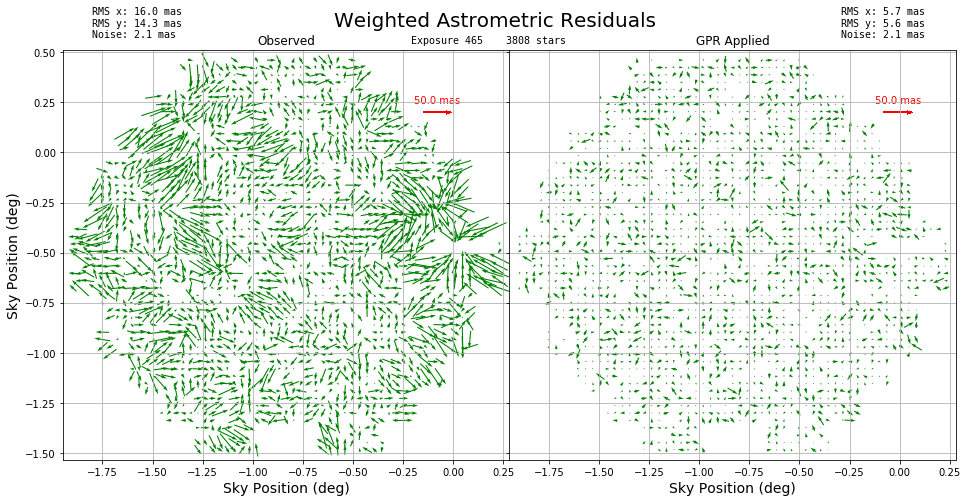

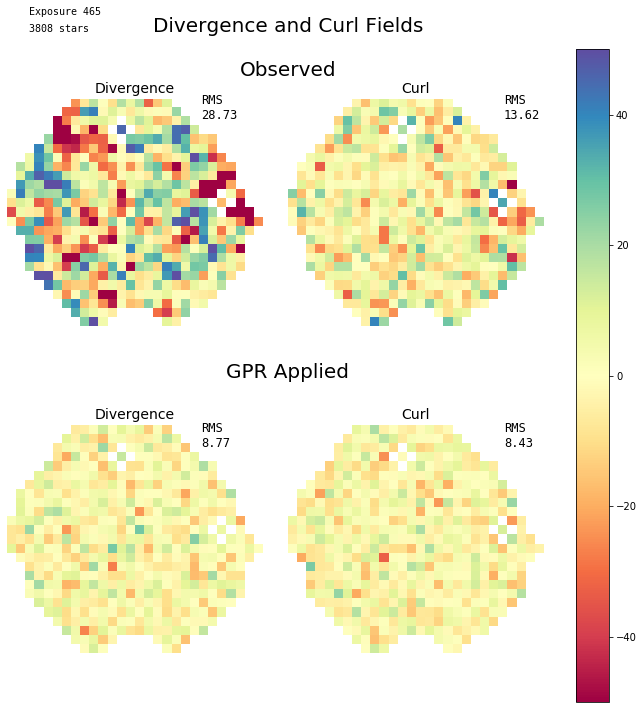

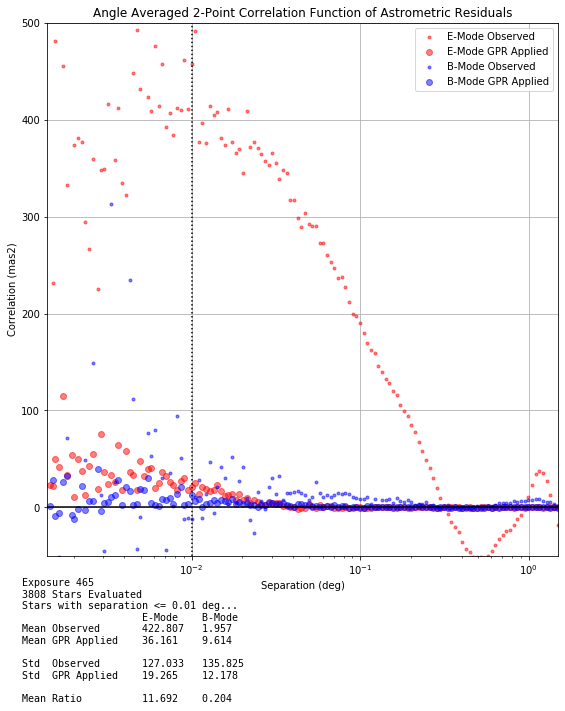

/home/fortino/DESworkspace/plotGPR.py:1195: RuntimeWarning: divide by zero encountered in true_divide
  xiplus /= counts
/home/fortino/DESworkspace/plotGPR.py:1195: RuntimeWarning: invalid value encountered in true_divide
  xiplus /= counts


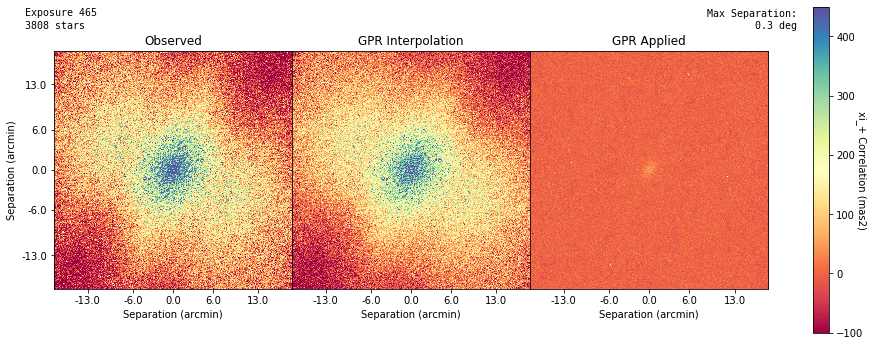

In [33]:
plotGPR.AstrometricResiduals(
    x, y, dx, dy, err,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2, err2=err2,
    title1="Observed", title2="GPR Applied",
    minPoints=100,
    pixelsPerBin=500,
    maxErr=50*u.mas,
    scale=350*u.mas,
    arrowScale=50*u.mas,
    savePath=None, saveExt="",
    plotShow=True,
    exposure=465
    )

plotGPR.DivCurl(
    x, y, dx, dy, err,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2, err2=err2,
    title1="Observed", title2="GPR Applied",
    minPoints=100,
    pixelsPerBin=1000,
    maxErr=50*u.mas,
    scale=50,
    savePath=None, saveExt=None,
    plotShow=True,
    exposure=465
)

plotGPR.Correlation(
    x, y, dx, dy,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2,
    title1="Observed", title2="GPR Applied",
    xiE_ON=True, xiB_ON=True,
#     xiplus_ON=True, ximinus_ON=True,
#     xicross_ON=True, xiz2_ON=True,
    rmin=5*u.arcsec, rmax=1.5*u.deg, dlogr=0.05,
    ylim=(-50, 500),
    sep=1e-2*u.deg, avgLine=True,
    savePath=None, saveExt=None,
    plotShow=True,
    exposure=465,
    showInfo=True
    )

plotGPR.Correlation2D(
    x, y, dx, dy,
    x2=x2, y2=y2, dx2=dx2, dy2=dy2,
    title1="Observed", title2="GPR Applied", title3="GPR Interpolation",
    rmax=0.3*u.deg, nBins=250,
    vmin=-100*u.mas**2, vmax=450*u.mas**2,
    savePath=None, saveExt=None,
    plotShow=True,
    exposure=465
    )